# Spatial-DC: a robust deep learning-based method for deconvolution of spatial proteomics
This analysis workflow demostreates the workflow for deconvolution of mass spectrometry (MS)-based spatial proteomics data by Spatial-DC.

[![python >3.9.20](https://img.shields.io/badge/python-3.9.20-brightgreen)](https://www.python.org/)

## Here is a demo code on python envirment to the deconvolution of Mouse PDAC data by Spatial-DC.

In [1]:
# Load necessary packages
import os
import sys
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc
from scipy.sparse import csr_matrix
from scipy.stats import pearsonr,spearmanr
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib as mat
from scipy import stats
# import cell2location
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import warnings
warnings.filterwarnings("ignore")

print(sys.version)
# plt.rcParams['font.size'] = 10
# plt.rcParams['pdf.fonttype'] = 42
# plt.rcParams['ps.fonttype'] = 42

3.9.20 | packaged by conda-forge | (main, Sep 30 2024, 17:49:10) 
[GCC 13.3.0]


In [2]:
# set the working directory
os.chdir("Spatial_DC/")
dataset_dir = "datasets/mouse_PDAC"
scaler = MinMaxScaler(feature_range=(0, 1))

## Overview of reference data and spatial proteomics data.

In [3]:
# Overview the reference proteomics data
sc_adata = sc.read_h5ad(f"{dataset_dir}/intersected_reference_proteomics.h5ad")

print(f"Protein intensity: {sc_adata.to_df().iloc[0:4,0:4]}\n")
print(f"The number of cells: {sc_adata.obs['celltype'].value_counts()}\n")
print("The total cells and intersected proteins:", sc_adata.shape)

Protein intensity: pid          A2A432         A2A863        A2A8U2        A2AAY5
PCC_1  42537.726562  180604.093750  30755.847656  86072.617188
PCC_2  27548.375000  167120.671875  24842.718750  67785.218750
PCC_3  16654.060547  157719.359375  32850.695312  81725.062500
PCC_4  31382.644531  167917.078125  63303.929688  74489.117188

The number of cells: celltype
PCC     5
CAF     5
T4      5
T8      5
Treg    5
B       5
NEU     5
MAC     5
MO      5
DC      5
Name: count, dtype: int64

The total cells and intersected proteins: (50, 2837)


In [4]:
ct_order = ['PCC', 'CAF', 'T4', 'T8', 'Treg', 'B', 
       'NEU', 'MAC', 'MO', 'DC']

In [5]:
# Overview the spatial proteomics data
sp_adata = sc.read_h5ad(f"{dataset_dir}/intersected_spatial_proteomics.h5ad")
print(f"Protein intensity: {sp_adata.to_df().iloc[0:4,0:4]}\n")
print("The total spots and intersected proteins:", sp_adata.shape)

Protein intensity: pid        A2A432     A2A863     A2A8U2     A2AAY5
ID2                                               
spot_1   8.045984  40.018787   4.014537   7.131848
spot_2  12.433872  37.670357   4.838315  46.889385
spot_3   2.792141  56.258595   8.180490  42.929935
spot_4  84.722740  53.198215  21.193108  15.791737

The total spots and intersected proteins: (108, 2837)


In [6]:
# Load Intersection of reference and spatial datasets
intersect = np.intersect1d(sc_adata.var_names, sp_adata.var_names)        
sp_adata = sp_adata[:, intersect].copy()
sc_adata = sc_adata[:, intersect].copy()

sc.pp.normalize_total(sc_adata)
sc.pp.normalize_total(sp_adata)

print(sc_adata.shape)
print(sp_adata.shape)

(50, 2837)
(108, 2837)


## Create deconvolution model and load trained DIS model

In [7]:
# Load Spatial-DC package
from Spatial_DC import SpatialDC

# conda install pytorch-cluster -c pyg

# Load trained DIS model
model_path = f"trained_model/mouse_PDAC/model_epoch200.pt"

spatial_dc = SpatialDC(sc_adata=sc_adata, sp_adata=sp_adata, reference_data_type="single_cell_type", dataset_type="real") 
spatial_dc.load_distribution_model(load_model_path = model_path)
pred_sp_adata = spatial_dc.transfer_distribution_model()

In [8]:
pred_sp_adata.uns["cellperc_initial"].iloc[0:4,0:4] # Overview of the intermediate cell percentages

,PCC,CAF,T4,T8
spot_1,0.120452,0.339786,0.378249,0.0
spot_2,0.207653,0.339314,0.305159,0.0
spot_3,0.144044,0.362069,0.323563,0.0
spot_4,0.059232,0.130525,0.512954,0.0


In [9]:
# Traine the self-supvervised model
spatial_dc.setup_self_supervised_model(k_graph=30, epochs=200)
spatial_dc.train_self_supervised_model()
spatial_dc.inference_self_supervised_model()

Training: 100%|██████████| 200/200 [00:49<00:00,  4.01epoch/s, loss=1.88903]


AnnData object with n_obs × n_vars = 108 × 2837
    obs: 'ID2', 'Spot', 'X', 'Y'
    uns: 'celltype_gd', 'cellperc_initial', 'protein_weight_pred', 'cellperc_refined', 'protein_weight_reconstruct'
    obsm: 'spatial'

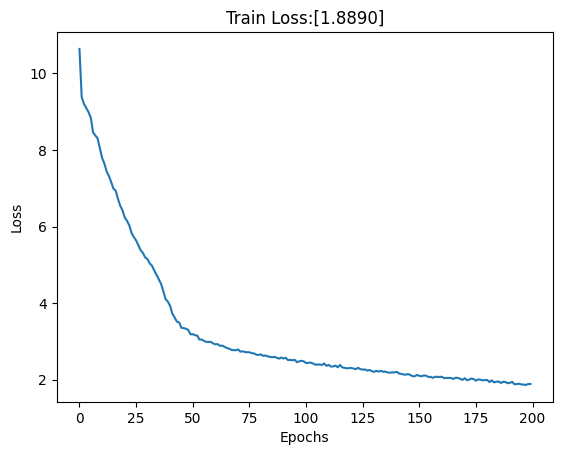

In [10]:
# print the train loss of SSM model
train_loss = spatial_dc.reconstruction_model.state["train_loss"]
epochs = spatial_dc.reconstruction_model.state["epochs"]
        
plt.plot(np.arange(0,epochs), train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Train Loss:[{"%.4f" % train_loss[-1]}]')
plt.show()
plt.close()   

In [11]:
# print the refined cell-type composition
pred_ct = pred_sp_adata[sp_adata.obs.index].uns["cellperc_refined"][ct_order]
print("Here is the predicted cell-type composition:")
print(pred_ct.iloc[0:10,0:4])

Here is the predicted cell-type composition:
              PCC       CAF        T4   T8
spot_1   0.126113  0.336358  0.358221  0.0
spot_2   0.204134  0.331188  0.303329  0.0
spot_3   0.145989  0.347568  0.312418  0.0
spot_4   0.082362  0.147269  0.493936  0.0
spot_5   0.165636  0.302137  0.302095  0.0
spot_6   0.153192  0.342682  0.285219  0.0
spot_7   0.029105  0.231418  0.415696  0.0
spot_8   0.047119  0.328338  0.375114  0.0
spot_9   0.119457  0.326650  0.339452  0.0
spot_10  0.078801  0.332377  0.392506  0.0


Here is the predicted cell-type composition


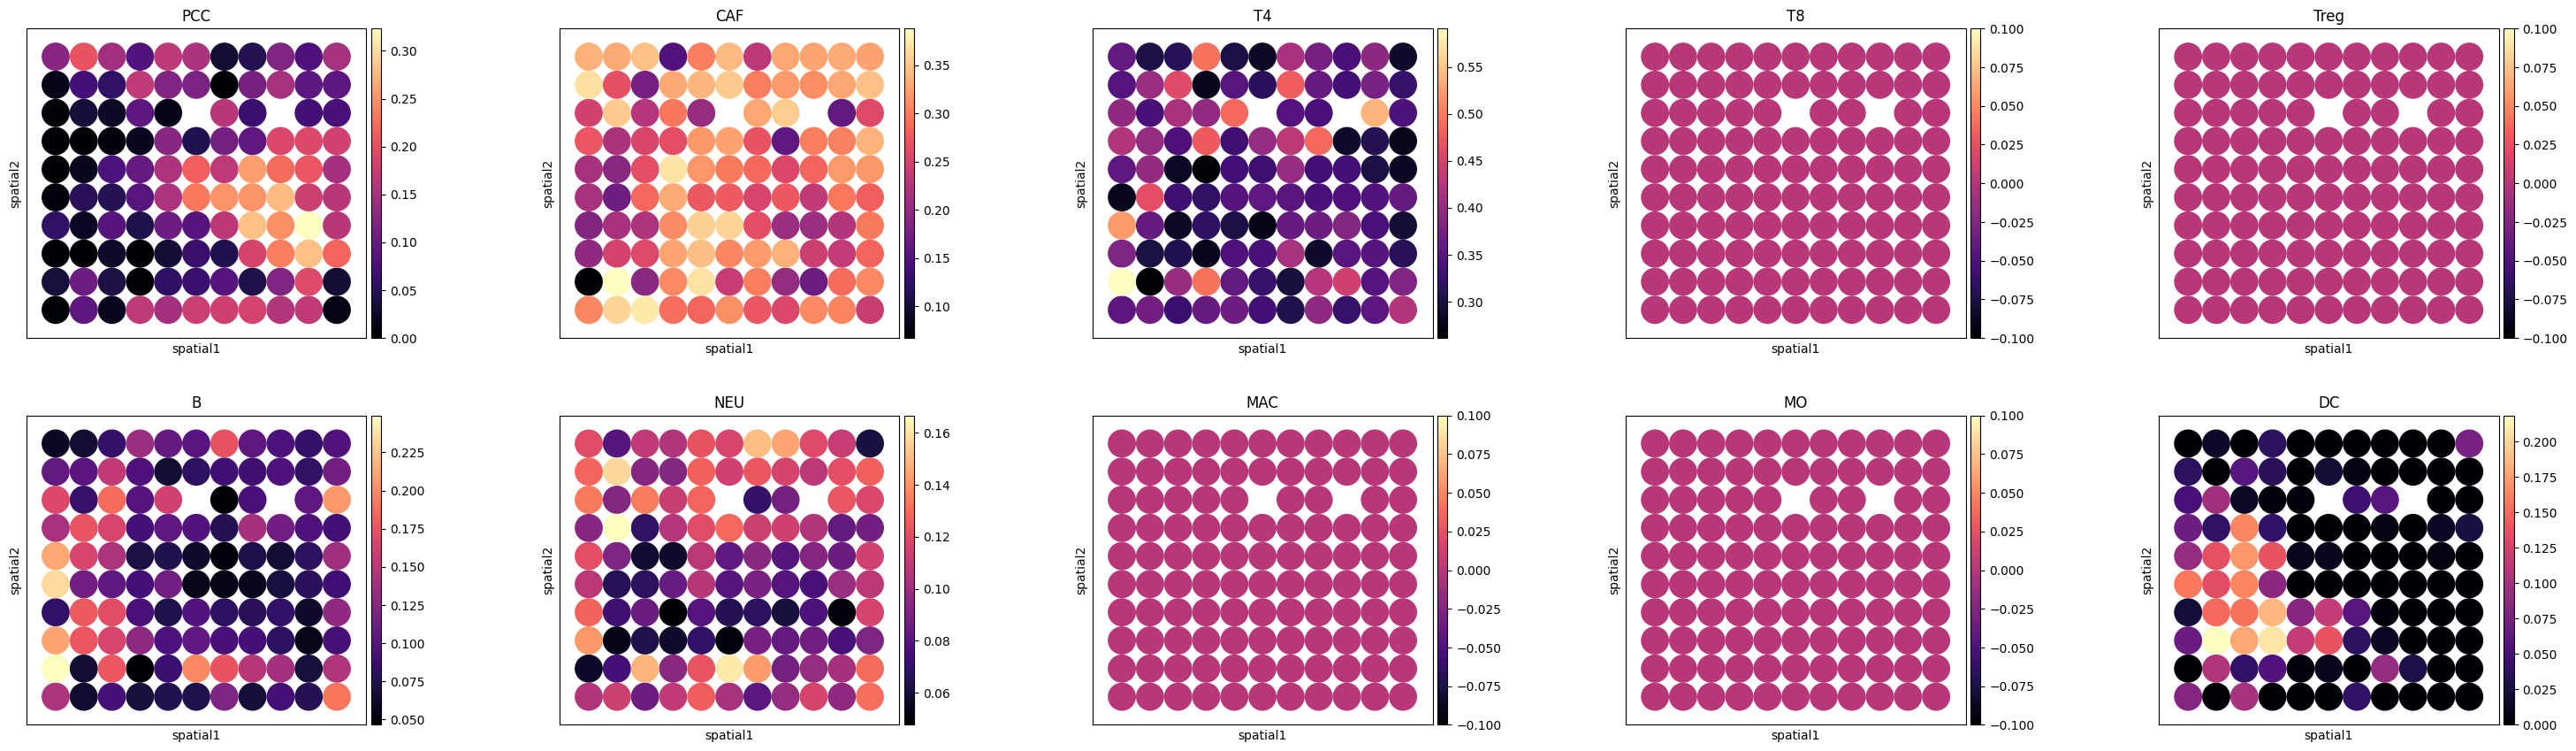

In [12]:
# Plot the distribution of predicted cell-type composition
sp_adata.obs = pred_ct[ct_order]
print("Here is the predicted cell-type composition")
sc.pl.spatial(sp_adata,spot_size=1,color=ct_order,color_map="magma",ncols=5,wspace=0.15)

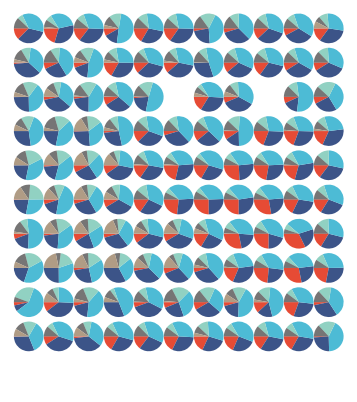

In [13]:
# Visualization the cell-type composition as pie charts
my_palette = ["#E64B35FF","#3C5488FF",  "#4DBBD5FF", "#00A087FF", "#8491B4FF","#91D1C2FF","#1B191999",  "#7E6148FF", "#B09C85FF", "#B09C85FF"]
sp_adata.uns["celltype_colors"] = my_palette

ct_order = ['PCC', 'CAF', 'T4', 'T8', 'Treg', 'B', 
       'NEU', 'MAC', 'MO', 'DC']

spatial = pd.DataFrame(sp_adata.obsm['spatial'], index=sp_adata.obs_names,columns=["x","y"])
            
# Begin Plot
fig, axs = plt.subplots(11, 11, figsize=(5, 5))
plt.subplots_adjust(hspace=-0.2, wspace=-0.2,right=0.8)

for i in range(11):  
    for j in range(11): 
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].axis('off')
        
for spot_num in range(spatial.shape[0]):
    i = spatial["y"][spot_num] - 1
    j = spatial["x"][spot_num] - 1
    
    
    axs[i, j].pie(np.array(pred_ct[ct_order])[spot_num].clip(0), colors=my_palette, radius=0.01, wedgeprops=dict(width=1, edgecolor='none'))
    axs[i, j].set_aspect('equal', 'box')
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])

plt.show()

## Assessment of reconstructing cell-type proteomic profiles by Spatial-DC

Protein intensity: pid            A2A432      A2A863    A2A8U2     A2AAY5
ID                                                    
spot_1_PCC   6.947267  153.435013  5.610480  17.715578
spot_1_CAF   8.728910   32.855278  7.011817  11.310419
spot_1_T4   12.488315   33.247818  3.546962   4.978637
spot_1_B    14.054561   12.053942  3.257776   4.221581

The total spots and intersected proteins: (592, 2837)
The number of cells: celltype
CAF    108
T4     108
B      108
NEU    108
PCC    101
DC      59
Name: count, dtype: int64

The total cells and intersected proteins: (592, 2837)


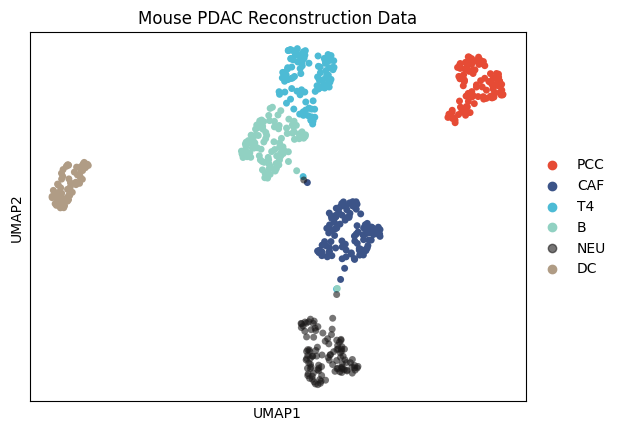

In [14]:
# Obtain the reconstructed adata from trained SSM
rec_scp_adata = spatial_dc.reconstruction(norm=True)

rec_scp_adata.uns["celltype_colors"] = my_palette
rec_scp_adata.obs["celltype"] = rec_scp_adata.obs["celltype"].astype("category")
rec_scp_adata.obs["celltype"] = rec_scp_adata.obs["celltype"].cat.reorder_categories(ct_order)

# UMAP of reconstructed adata
rec_scp_adata = rec_scp_adata[rec_scp_adata.obs["cellperc"] > 0,:]

print(f"Protein intensity: {rec_scp_adata.to_df().iloc[0:4,0:4]}\n")
print("The total spots and intersected proteins:", rec_scp_adata.shape)

print(f"The number of cells: {rec_scp_adata.obs['celltype'].value_counts()}\n")
print("The total cells and intersected proteins:", rec_scp_adata.shape)

sc.pp.normalize_total(rec_scp_adata)
sc.pp.log1p(rec_scp_adata)
sc.pp.scale(rec_scp_adata)
sc.pp.pca(rec_scp_adata)
sc.pp.neighbors(rec_scp_adata, n_pcs=20, n_neighbors=10)
sc.tl.umap(rec_scp_adata)
sc.pl.umap(rec_scp_adata, color=["celltype"], size=100, title="Mouse PDAC Reconstruction Data")